In [4]:
# %load script.py
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn import svm
import matplotlib.pyplot as plt

from scipy.special import softmax
import time

def preprocess():
    """ 
     Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set
    """

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    n_feature = mat.get("train1").shape[1]
    n_sample = 0
    for i in range(10):
        n_sample = n_sample + mat.get("train" + str(i)).shape[0]
    n_validation = 1000
    n_train = n_sample - 10 * n_validation

    # Construct validation data
    validation_data = np.zeros((10 * n_validation, n_feature))
    for i in range(10):
        validation_data[i * n_validation:(i + 1) * n_validation, :] = mat.get("train" + str(i))[0:n_validation, :]

    # Construct validation label
    validation_label = np.ones((10 * n_validation, 1))
    for i in range(10):
        validation_label[i * n_validation:(i + 1) * n_validation, :] = i * np.ones((n_validation, 1))

    # Construct training data and label
    train_data = np.zeros((n_train, n_feature))
    train_label = np.zeros((n_train, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("train" + str(i)).shape[0]
        train_data[temp:temp + size_i - n_validation, :] = mat.get("train" + str(i))[n_validation:size_i, :]
        train_label[temp:temp + size_i - n_validation, :] = i * np.ones((size_i - n_validation, 1))
        temp = temp + size_i - n_validation

    # Construct test data and label
    n_test = 0
    for i in range(10):
        n_test = n_test + mat.get("test" + str(i)).shape[0]
    test_data = np.zeros((n_test, n_feature))
    test_label = np.zeros((n_test, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("test" + str(i)).shape[0]
        test_data[temp:temp + size_i, :] = mat.get("test" + str(i))
        test_label[temp:temp + size_i, :] = i * np.ones((size_i, 1))
        temp = temp + size_i

    # Delete features which don't provide any useful information for classifiers
    sigma = np.std(train_data, axis=0)
    index = np.array([])
    for i in range(n_feature):
        if (sigma[i] > 0.001):
            index = np.append(index, [i])
    train_data = train_data[:, index.astype(int)]
    validation_data = validation_data[:, index.astype(int)]
    test_data = test_data[:, index.astype(int)]

    # Scale data to 0 and 1
    train_data /= 255.0
    validation_data /= 255.0
    test_data /= 255.0

    return train_data, train_label, validation_data, validation_label, test_data, test_label


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def blrObjFunction(initialWeights, *args):
    """
    blrObjFunction computes 2-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector (w_k) of size (D + 1) x 1 
        train_data: the data matrix of size N x D
        labeli: the label vector (y_k) of size N x 1 where each entry can be either 0 or 1 representing the label of corresponding feature vector

    Output: 
        error: the scalar value of error function of 2-class logistic regression
        error_grad: the vector of size (D+1) x 1 representing the gradient of
                    error function
    """
    train_data, labeli = args
    n_data = train_data.shape[0]
    n_features = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_features + 1, 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    if(debug): print(f'train_data shape: {train_data.shape}')
    if(debug): print(f'w shape: {initialWeights.shape}')
    train_data_bias = np.column_stack((np.ones((n_data, 1)), train_data))
    if(debug): print(f'train_data_bias shape: {train_data.shape}')
    
    theta_n = sigmoid(np.matmul(train_data_bias, np.matrix(initialWeights).T))
    if(debug): print(f'theta_n shape: {theta_n.shape}')
    error = (-1/n_data) * np.sum(np.multiply(labeli, np.log(theta_n)) + np.multiply((1 - labeli), np.log(1 - theta_n)))
    if(debug): print(f'error: {error}')
    
    error_grad = (1/n_data) * (np.sum(np.multiply((theta_n - labeli), train_data_bias), axis = 0)).T
    error_grad = np.asarray(error_grad).flatten()
    if(debug): print(f'error_grad shape: {error_grad.shape}')

    return error, error_grad


def blrPredict(W, data):
    """
     blrObjFunction predicts the label of data given the data and parameter W 
     of Logistic Regression
     
     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight 
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D
         
     Output: 
         label: vector of size N x 1 representing the predicted label of 
         corresponding feature vector given in data matrix

    """
    label = np.zeros((data.shape[0], 1))
    
    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    data_bias = np.column_stack(((np.ones((data.shape[0], 1))), data))
    label = np.argmax(sigmoid(np.matmul(data_bias, W)), axis = 1)
    label = np.matrix(label).T
    
    return label

def mlrObjFunction(params, *args):
    """
    mlrObjFunction computes multi-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights_b: the weight vector of size (D + 1) x 10
        train_data: the data matrix of size N x D
        labeli: the label vector of size N x 10 where each entry can be either 0 or 1
                representing the label of corresponding feature vector

    Output:
        error: the scalar value of error function of multi-class logistic regression
        error_grad: the vector of size (D+1) x 10 representing the gradient of
                    error function
    """
    train_data, labeli = args
    n_data = train_data.shape[0]
    n_feature = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_feature + 1, n_class))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    
    initialWeights = params.reshape((n_feature+1, n_class))
    # print(f"initialWeights: {initialWeights}")
    if(debug): print(f'params type: {type(params)}')
    if(debug): print(f'params shape: {params.shape}')
    if(debug): print(f'train_data shape: {train_data.shape}')
    if(debug): print(f'w shape: {initialWeights.shape}')
    train_data_bias = np.column_stack((np.ones((n_data, 1)), train_data))
    if(debug): print(f'train_data_bias shape: {train_data.shape}')
    
    # theta_nk = softmax(np.matmul(train_data_bias, initialWeights), axis=1)
    #Softmax function
    num = np.exp(np.matmul(train_data_bias, initialWeights))
    if(debug): print(f'num shape: {num.shape}')
    dem = np.sum(num, axis = 1)
    if(debug): print(f'dem shape: {dem.shape}')
    theta_nk = np.divide(num, dem.reshape((dem.shape[0], 1)))
    if(debug): print(f'theta_nk shape: {theta_nk.shape}')
    error = -1*np.sum(np.multiply(labeli, np.log(theta_nk)))
    if(debug): print(f'error: {error}')
   
    error_grad = np.matmul((theta_nk - labeli).T, train_data_bias).T
    # error_grad = np.matmul(train_data_bias.T, (theta_nk - labeli))
        
    error_grad = error_grad.flatten()
    # if(debug): print(f'error grad type: {type(error_grad)}')
    # if(debug): print(f'error shape: {error_grad.shape}')
    
    return error, error_grad


def mlrPredict(W, data):
    """
     mlrObjFunction predicts the label of data given the data and parameter W
     of Logistic Regression

     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D

     Output:
         label: vector of size N x 1 representing the predicted label of
         corresponding feature vector given in data matrix

    """
    label = np.zeros((data.shape[0], 1))
   
    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    data_bias = np.column_stack((np.ones((data.shape[0], 1)), data))
    # pred = softmax(np.matmul(data_bias, W), axis=1)
    #Softmax function
    num = np.exp(np.matmul(data_bias, W))
    if(debug): print(f'num shape: {num.shape}')
    dem = np.sum(num, axis = 1)
    if(debug): print(f'dem shape: {dem.shape}')
    theta_nk = np.divide(num, dem.reshape((dem.shape[0], 1)))
    label = np.argmax(theta_nk, axis = 1)
    label = np.matrix(label).T

    return label


"""
Script for Logistic Regression
"""
start_time = time.time()
debug = False

train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# number of classes
n_class = 10

# number of training samples
n_train = train_data.shape[0]

# number of features
n_feature = train_data.shape[1]

Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()

# # Logistic Regression with Gradient Descent
# W = np.zeros((n_feature + 1, n_class))
# initialWeights = np.zeros((n_feature + 1, 1))
# opts = {'maxiter': 100}
# for i in range(n_class):
#     print(f"\n|||||NEW {i}||||||||")
#     labeli = Y[:, i].reshape(n_train, 1)
#     args = (train_data, labeli)
#     nn_params = minimize(blrObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
#     W[:, i] = nn_params.x.reshape((n_feature + 1,))
# print("Training Time BLR: %.2f seconds" % (time.time() - start_time))
    
# # Find the accuracy on Training Dataset
# predicted_label = blrPredict(W, train_data)
# print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label).astype(float))) + '%')

# # Find the accuracy on Validation Dataset
# predicted_label2 = blrPredict(W, validation_data)
# print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label2 == validation_label).astype(float))) + '%')

# # Find the accuracy on Testing Dataset
# predicted_label3 = blrPredict(W, test_data)
# print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label3 == test_label).astype(float))) + '%')
# print("Total Time BLR: %.2f seconds" % (time.time() - start_time))
# """
# Script for Support Vector Machine
# """

# print('\n\n--------------SVM-------------------\n\n')
##################
# YOUR CODE HERE #
##################


# """
# Script for Extra Credit Part
# """
# FOR EXTRA CREDIT ONLY
start_time = time.time()
W_b = np.zeros((n_feature + 1, n_class))
initialWeights_b = np.zeros((n_feature + 1, n_class))
opts_b = {'maxiter': 100}

args_b = (train_data, Y)
nn_params = minimize(mlrObjFunction, initialWeights_b, jac=True, args=args_b, method='CG', options=opts_b)
W_b = nn_params.x.reshape((n_feature + 1, n_class))
print("Training Time MLR: %.2f seconds" % (time.time() - start_time))
# Find the accuracy on Training Dataset
predicted_label_b = mlrPredict(W_b, train_data)
print('\nTraining set Accuracy:' + str(100 * np.mean((predicted_label_b == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label_b2 = mlrPredict(W_b, validation_data)
print('Validation set Accuracy:' + str(100 * np.mean((predicted_label_b2 == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label_b3 = mlrPredict(W_b, test_data)
print('Testing set Accuracy:' + str(100 * np.mean((predicted_label_b3 == test_label).astype(float))) + '%')
print("\nTotal Time MLR: %.2f seconds" % (time.time() - start_time))

Training Time MLR: 28.87 seconds

Training set Accuracy:93.108%
Validation set Accuracy:92.36999999999999%
Testing set Accuracy:92.53%

Total Time MLR: 29.09 seconds


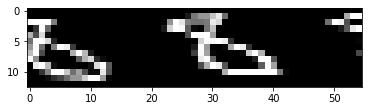

Truth label: 8, Predicated Label: 5


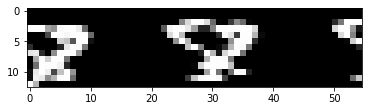

Truth label: 8, Predicated Label: 7


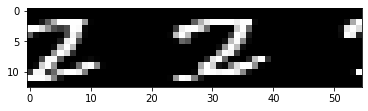

Truth label: 2, Predicated Label: 8


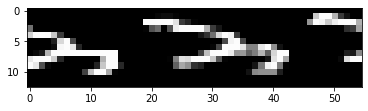

Truth label: 3, Predicated Label: 2





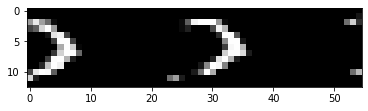

Truth label: 7, Predicated Label: 1


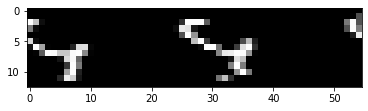

Truth label: 9, Predicated Label: 4


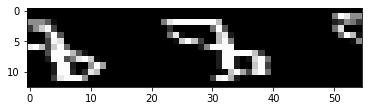

Truth label: 8, Predicated Label: 3


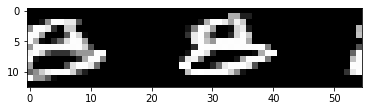

Truth label: 8, Predicated Label: 3


In [7]:
error_indices = []
for i in range(10000):
    if(predicted_label_b3[i] != test_label[i]):
        error_indices.append(i)
random_indices = np.random.choice(error_indices, size=8)    

for index, i in enumerate(random_indices):
    if(index%4==0): print("\n\n")
    plt.gray()
    plt.imshow(test_data[i].reshape((13,55)))
    plt.show()
    print(f"Truth label: {test_label[i][0].astype(int)}, Predicated Label: {np.asarray(predicted_label_b3[i])[0][0]}")

In [ ]:
# wrong_indices_train = []
# for i in ((predicted_label == train_label).astype(float)):
#     if(i == 0):
#         wrong_indices_train.append(i)
# print(f"train: {len(wrong_indices_train)}")

# wrong_indices_valid = []
# for i in ((predicted_label2 == validation_label).astype(float)):
#     if(i == 0):
#         wrong_indices_valid.append(i)
# print(f"valid: {len(wrong_indices_valid)}")

# wrong_indices_test = []
# for i in ((predicted_label3 == test_label).astype(float)):
#     if(i == 0):
#         wrong_indices_test.append(i)
# print(f"test: {len(wrong_indices_test)}")

wrong_label_train = []
right_label_train = []
for i in (range(50000)):
    if(predicted_label_b[i] != train_label[i]):
        wrong_label_train.append(train_label[i])
    else:
        right_label_train.append(train_label[i])
(unique, counts) = np.unique(np.array(wrong_label_train), return_counts=True)
print(f"             {[*range(10)]}")
print(f"train wrong: {counts}")
(unique, counts2) = np.unique(np.array(right_label_train), return_counts=True)
print(f"train right: {counts2}")
print(f"train total: {counts+counts2}")

wrong_label_test = []
right_label_test = []
for i in (range(10000)):
    if(predicted_label_b3[i] != test_label[i]):
        wrong_label_test.append(test_label[i])
    else:
        right_label_test.append(test_label[i])
(unique, counts3) = np.unique(np.array(wrong_label_test), return_counts=True)
print(f"\ntest wrong: {counts3}")
(unique, counts4) = np.unique(np.array(right_label_test), return_counts=True)
print(f"test right: {counts4}")
print(f"test total: {counts3+counts4}")


In [ ]:
import pickle
pickle.dump(W, open( "weights.p", "wb" ))

In [ ]:
import pickle
with open(r"weights.p", "rb") as input_file:
    W = pickle.load(input_file)
    
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# Find the accuracy on Training Dataset
predicted_label = blrPredict(W, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label2 = blrPredict(W, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label2 == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label3 = blrPredict(W, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label3 == test_label).astype(float))) + '%')


In [ ]:
error_indices = []
for i in range(10000):
    if(predicted_label3[i] != test_label[i]):
        error_indices.append(i)
random_indices = np.random.choice(error_indices, size=8)    

for index, i in enumerate(random_indices):
    if(index%4==0): print("\n\n")
    plt.gray()
    plt.imshow(test_data[i].reshape((13,55)))
    plt.show()
    print(f"Truth label: {test_label[i][0].astype(int)}, Predicated Label: {np.asarray(predicted_label3[i])[0][0]}")
   

In [ ]:
n_test = test_data.shape[0]
Y2 = np.zeros((n_test, n_class))
for i in range(n_class):
    Y2[:, i] = (test_label == i).astype(int).ravel()